Cell 0 – Setup

In [1]:
from pathlib import Path
import sys

# Ensure repo root is on sys.path
repo_root = Path("../../").resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))
print("CWD:", Path.cwd())


CWD: /home/geekadmin/code/snoiq-experiments/notebooks/01-ingestion


Cell 1 – Imports & paths

In [2]:
from src.ingestion.mrms import open_mrms_qpe
import xarray as xr
import pandas as pd

# Define file paths
mrms_path = Path("../../data/raw/mrms/20250115/MRMS_MultiSensor_QPE_01H_Pass2_00.00_20250115-210000.grib2")
table_path = Path("../../data/refs/UserTable_MRMS_v12.2.csv")
print("MRMS file:", mrms_path.exists(), "|", "Table:", table_path.exists())


MRMS file: True | Table: True


Cell 2 – Load and inspect

In [3]:
qpe = open_mrms_qpe(mrms_path, user_table_csv=table_path)
print(qpe.name, qpe.dims, qpe.attrs.get("units"))
print("Mean:", float(qpe.mean()), "Max:", float(qpe.max()))
qpe


QPE_01H_Pass2 ('latitude', 'longitude') mm
Mean: 0.03645513579249382 Max: 38.0


<xarray.DataArray 'QPE_01H_Pass2' (latitude: 3500, longitude: 7000)> Size: 98MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(3500, 7000), dtype=float32)
Coordinates:
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    time            datetime64[ns] 8B 2025-01-15T21:00:00
    step            timedelta64[ns] 8B 00:00:00
    heightAboveSea  float64 8B 0.0
    valid_time      datetime64[ns] 8B 2025-01-15T21:00:00
Attributes:
    long_name:        MRMS MultiSensor QPE 1h (Pass2)
    units:            mm
    product_token:    MultiSensor_QPE_01H_Pass2_00.00
    filename:         MRMS_MultiSensor_QPE_01H_Pass2_00.00_20250115-210000.grib2
    source:           NOAA MRMS PDS
    MRMS_discipline:  209
    MRMS_category:    6
    MRMS_parameter:   37

Cell 3 – Enrich from table (optional preview)

In [4]:
tbl = pd.read_csv(table_path)
tbl["Name"] = tbl["Name"].astype(str).str.strip()
tbl[tbl["Name"].str.contains("MultiSensor_QPE_01H_Pass2", case=False, na=False)].reset_index(drop=True)


,Discipline,Category,Parameter,Name,Frequency,Unit,Missing,Range Folded,No Coverage,Description,Notes
0,209,6.0,37.0,MultiSensor_QPE_01H_Pass2,60-min,mm,-1.0,NaN,-3.0,Multi-sensor accumulation 1-hour (2-hour latency),NaN


Cell 4 – Verify against operational table

In [5]:
assert qpe.attrs["units"] == "mm"
assert qpe.name == "QPE_01H_Pass2"
assert set(qpe.dims) == {"latitude", "longitude"}
print("✅ MRMS QPE 1H Pass2 passes canonical checks.")


✅ MRMS QPE 1H Pass2 passes canonical checks.


Cell 5 – Visual sanity

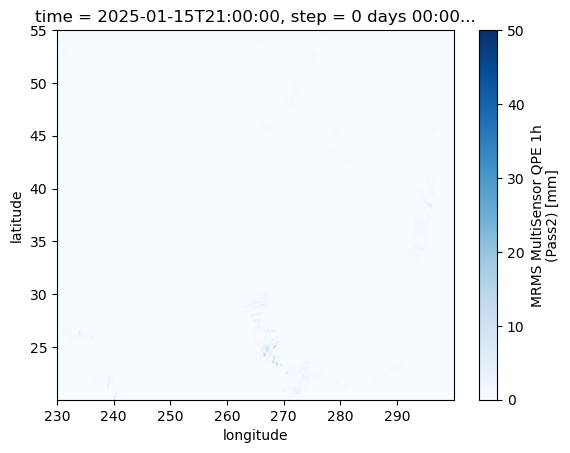

In [6]:
qpe.plot(cmap="Blues", vmax=50)


Cell 6 – SLR demo

Mean snow depth (in): 0.017462105291043674 Max: 18.202099737532812


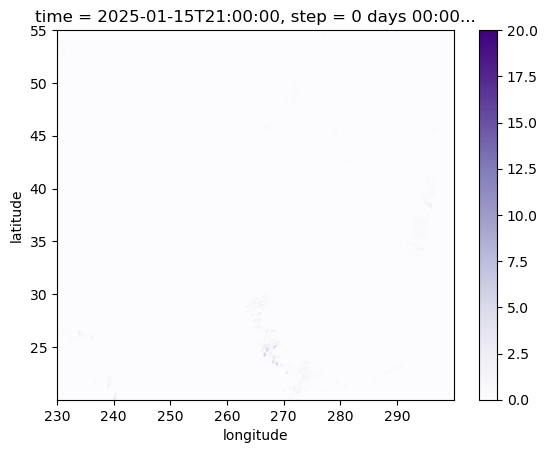

In [7]:
from src.physics.snow import snowfall_depth_mm, to_inches

snow_in = to_inches(snowfall_depth_mm(qpe, t2m_c=-5))
print("Mean snow depth (in):", float(snow_in.mean()), "Max:", float(snow_in.max()))
snow_in.plot(cmap="Purples", vmax=20)


Cell 7 – Save golden crop

In [8]:
# dynamic center crop
ny, nx = qpe.shape
crop = qpe.isel(latitude=slice(ny//2 - 32, ny//2 + 32),
                longitude=slice(nx//2 - 32, nx//2 + 32))
path = Path("../../data/golden/mrms_qpe01h_pass2_crop.nc")
path.parent.mkdir(parents=True, exist_ok=True)
crop.to_netcdf(path)
print("Golden crop saved →", path)


Golden crop saved → ../../data/golden/mrms_qpe01h_pass2_crop.nc
